In [9]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torchvision.models as models
import numpy as np
import copy
import cv2
import math
from torchvision.utils import save_image

I took style and content image for my model 

In [10]:
STYLE_IMAGE = "C:\\Users\\Manoj Kumar\\Desktop\\machine learning self\\s8.jpg"
CONTENT_IMAGE = "C:\\Users\\Manoj Kumar\\Desktop\machine learning self\\c8.jpg"

In [11]:
SMOOTH = True
SHOW_MASKS = False
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SELECT_MATCHES = True # set to True to select color correspondences in palettes
EPS = 1e-6
SIGMA = 0.3 # 0.25 and 0.3 work well in most cases
PALETTE_SIZE = 5
ADD_BLACK_WHITE = False
STYLE_LOSS_WEIGHT = 10000
CONTENT_LOSS_WEIGHT = 1
COLOR_DISTANCE = 'chroma_L2'  # Options: 'chroma_L2', 'L2'
STYLE_FEATURE_DISTANCE = 'L2'  # Options: 'L2', 'COSINE'
CONTENT_FEATURE_DISTANCE = 'L2'  # Options: 'L2', 'COSINE'
OPTIMIZER = 'LBFGS'  # Options: 'LBFGS', 'Adam', 'Adagrad'
LR = 0.5
ITERATIONS = 300
IMAGE_SIZE = 512
# desired size of the output image
imsize = IMAGE_SIZE
# desired depth layers to compute style/content losses :
content_layers_default = ['conv_4', 'conv_5']
color_aware_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

in below snippet utility functions are made for common color image processing tasks. It includes functions for converting images to float32 format, handling RGB channels, transforming color spaces (RGB to Lab), and performing operations on color histograms, such as clipping low-density values and computing density sizes. Additionally, there are functions for adjusting ranges for plotting purposes.

In [12]:
import numpy as np
import cv2

def to32F(img):
    return img.astype(np.float32) / 255.0 if img.dtype != np.float32 else img

def rgb(img):
    if len(img.shape) == 2:
        return np.stack([img] * 3, axis=-1)
    elif img.shape[2] == 3:
        return img
    return img[:, :, :3]

def rgb2Lab(img):
    img_rgb = rgb(img)
    return cv2.cvtColor(img_rgb, cv2.COLOR_RGB2LAB)

def Lab2rgb(img):
    return cv2.cvtColor(img, cv2.COLOR_LAB2RGB)

def _isGray(image):
    return len(image.shape) == 2

def isVector(x):
    return x.size == x.shape[0]

def isMatrix(x):
    return not isVector(x)

def normVectors(x):
    return np.sqrt(l2NormVectors(x))

def l2NormVectors(x):
    return np.square(x) if isVector(x) else np.einsum('...i,...i', x, x)

def colorCoordinates(color_ids, num_bins, color_range):
    c_min, c_max = color_range
    return c_min + (np.array(color_ids).T * (c_max - c_min)) / float(num_bins - 1.0)

def colorDensities(hist_bins):
    hist_positive = hist_bins > 0.0
    color_densities = hist_bins[hist_positive] / np.max(hist_bins[hist_positive])
    return np.float32(color_densities)

def rgbColors(hist_bins, color_bins):
    hist_positive = hist_bins > 0.0
    colors = np.clip(color_bins[hist_positive, :], 0.0, 1.0)
    return colors

def clipLowDensity(hist_bins, color_bins, alpha):
    density_mean = np.mean(hist_bins)
    low_density = hist_bins < density_mean * alpha
    hist_bins[low_density] = 0.0
    color_bins[low_density, :] = 0.0

def densitySizes(color_densities, density_size_range):
    density_size_min, density_size_max = density_size_range
    density_size_factor = density_size_max / density_size_min
    return density_size_min * np.power(density_size_factor, color_densities)

def range2ticks(tick_range, decimals=1):
    ticks = np.around(tick_range, decimals=decimals)
    ticks[ticks > 10] = np.rint(ticks[ticks > 10])
    return ticks

def range2lims(tick_range):
    unit = 0.1 * (tick_range[:, 1] - tick_range[:, 0])
    lim = np.array(tick_range)
    lim[:, 0] += -unit
    lim[:, 1] += unit
    return lim

I made a class ColorPixels that processes an input image, converting it to Lab color space if specified. It provides methods (rgb, Lab, and pixels) to extract pixel values with downsampling based on the specified color space and number of pixels.
__init__: Initializes the ColorPixels class, converting the input image to float32 format and setting the number of pixels for downsampling.

rgb: Returns RGB pixels of the image using the default color space, with downsampling based on the specified number of pixels.

Lab: Returns Lab color space pixels of the image with downsampling.

pixels: Returns pixels of the image based on the specified color space (default is RGB), incorporating downsampling logic to reduce the number of pixels

In [13]:
class ColorPixels:

    def __init__(self, image, num_pixels=1000):
        self._image = to32F(image)
        self._num_pixels = num_pixels
        self._rgb_pixels = None
        self._Lab = None

    def rgb(self):
        return self.pixels()

    def Lab(self):
        return self.pixels(color_space="Lab")

    def pixels(self, color_space="rgb"):
        image = rgb2Lab(self._image) if color_space == "Lab" else np.array(self._image)

        if _isGray(image):
            return image.flatten()[::int(image.size / self._num_pixels)]

        return image.reshape((-1, image.shape[2]))[::int(image.size / self._num_pixels)]

a 3D color histogram class (Hist3D) that computes and manages color histograms in a specified color space. It includes methods to retrieve information about color space, color IDs, color coordinates, color densities, RGB colors, and the color range. The class internally computes target pixels, color range, and histograms, with additional functions for clipping low densities.

In [14]:
class Hist3D:
    def __init__(self, image, num_bins=16, alpha=0.1, color_space='rgb'):
        self._compute_target_pixels(image, color_space)
        self._num_bins = num_bins
        self._alpha = alpha
        self._color_space = color_space
        self._compute_color_range()
        self._compute_histogram()

    def colorSpace(self):
        return self._color_space

    def colorIDs(self):
        return np.where(self._hist_positive())

    def colorCoordinates(self):
        return colorCoordinates(self.colorIDs(), self._num_bins, self._color_range)

    def colorDensities(self):
        return colorDensities(self._hist_bins)

    def rgbColors(self):
        return rgbColors(self._hist_bins, self._color_bins)

    def colorRange(self):
        return self._color_range

    def _compute_target_pixels(self, image, color_space):
        color_pixels = ColorPixels(image)
        self._pixels = color_pixels.pixels(color_space)
        self._rgb_pixels = color_pixels.rgb()

    def _compute_color_range(self):
        pixels = self._pixels
        self._color_range = [np.min(pixels, axis=0), np.max(pixels, axis=0)]

    def _compute_histogram(self):
        num_bins = self._num_bins
        c_min, c_max = self._color_range

        color_ids = (num_bins - 1) * (self._pixels - c_min) / (c_max - c_min)
        color_ids = np.int32(color_ids)

        hist_bins = np.zeros((num_bins, num_bins, num_bins), dtype=np.float32)
        color_bins = np.zeros((num_bins, num_bins, num_bins, 3), dtype=np.float32)

        for pi, color_id in enumerate(color_ids):
            hist_bins[color_id[0], color_id[1], color_id[2]] += 1
            color_bins[color_id[0], color_id[1], color_id[2]] += self._rgb_pixels[pi]

        self._hist_bins = hist_bins
        hist_positive = self._hist_bins > 0.0

        for ci in range(3):
            color_bins[hist_positive, ci] /= self._hist_bins[hist_positive]

        self._color_bins = color_bins
        self._clip_low_density()

    def _clip_low_density(self):
        clipLowDensity(self._hist_bins, self._color_bins, self._alpha)

    def _hist_positive(self):
        return self._hist_bins > 0.0


This code defines a PaletteSelection class for automatically selecting a color palette. It computes the palette by iteratively choosing colors based on their weights, determined by distances to previously selected colors. The class provides methods to retrieve palette coordinates and colors. Internally, it calculates dark and bright colors, updates the palette, and adjusts color weights.

In [15]:
class PaletteSelection:
    def __init__(self, color_coordinates, color_densities, rgb_colors, num_colors=7, sigma=70.0):
        self._color_coordinates = color_coordinates
        self._color_densities = color_densities
        self._rgb_colors = rgb_colors
        self._num_colors = num_colors
        self._sigma = sigma
        self._palette_coordinates = []
        self._palette_colors = []
        self._dark_bright = self._compute_dark_bright_colors()
        self._color_weights = np.array(self._color_densities)
        self._compute_palette()

    def paletteCoordinates(self):
        return self._palette_coordinates

    def paletteColors(self):
        return self._palette_colors

    def _compute_palette(self):
        for _ in range(self._num_colors):
            palette_coordinate = self._update_palette()
            self._update_weight(palette_coordinate)

    def _compute_dark_bright_colors(self):
        rgb_colors = self._rgb_colors
        intensities = normVectors(rgb_colors)
        c_dark = self._color_coordinates[np.argmin(intensities)]
        c_bright = self._color_coordinates[np.argmax(intensities)]
        return [c_dark, c_bright]

    def _update_palette(self):
        color_id = np.argmax(self._color_weights)
        palette_coordinate = self._color_coordinates[color_id]
        self._palette_coordinates.append(palette_coordinate)

        palette_color = self._rgb_colors[color_id]
        self._palette_colors.append(palette_color)
        return palette_coordinate

    def _update_weight(self, palette_coordinate):
        dists = normVectors(self._color_coordinates - palette_coordinate)
        factors = 1.0 - np.exp(-dists**2 / (self._sigma**2))
        self._color_weights *= factors


I used PyTorch module  CreateMask that  generates masks based on an input image tensor x and a given color palette. It performs color interpolation and distance-based weighting to create masks corresponding to each color in the palette. The distance metric, smoothing, and interpolation are controlled by parameters such as distance, smooth, and sigma. The masks are then returned as a tensor. If no color palette is provided, a NameError is raised.

In [16]:

class CreateMask(nn.Module):
    def __init__(self, insz=imsize, color_palette=None, sigma=SIGMA, smooth=SMOOTH, distance=COLOR_DISTANCE):
        super(CreateMask, self).__init__()
        self.color_palette = color_palette
        self.insz = insz
        self.device = DEVICE
        self.sigma = sigma
        self.distance = distance
        self.smooth = smooth

    def forward(self, x):
        if self.color_palette is None:
            raise NameError('No color palette is given')

        x = torch.clamp(x, 0, 1)
        I = F.interpolate(x[:, :3, :, :], size=(self.insz, self.insz),
                          mode='bilinear', align_corners=False)

        masks = torch.zeros(1, self.color_palette.shape[0], self.insz, self.insz, device=DEVICE)

        if self.distance == 'chroma_L2':
            I = I / (torch.unsqueeze(torch.sum(I, dim=1), dim=1) + EPS)

        for c in range(self.color_palette.shape[0]):
            color = self.color_palette[c, :].view(1, 3, 1, 1)

            if self.distance == 'chroma_L2':
                color = color / (torch.unsqueeze(torch.sum(color, dim=1), dim=1) + EPS)

            dist = torch.sqrt(torch.sum((I - color) ** 2, dim=1))
            weight = torch.exp(-1 * (dist / self.sigma) ** 2)

            if self.smooth:
                weight = F.conv2d(torch.unsqueeze(weight, dim=0),
                                  gaussian_kernel,
                                  bias=None, stride=1, padding=7)

            masks[0, c, :, :] = weight

        return masks

Gram matrix from a given 4D input tensor, capturing feature correlations. The result is normalized by the total number of elements in the tensor.

In [17]:
def gram_matrix(input):
    a, b, c, d = input.size() 
    features = input.view(a * b, c * d)  
    G = torch.mm(features, features.t())  # compute the gram product
    return G.div(a * b * c * d)

below function computes a masked Gram matrix for an input tensor using a set of masks. It iterates over each mask, normalizes the values, and calculates the Gram matrix for the input features. The final output is the averaged and normalized Gram matrices across all masks.

In [18]:
def masked_gram_matrix(input, masks):
    k = masks.shape[1]
    a, b, c, d = input.size()
    masks = F.interpolate(masks, size=(c, d), mode='bilinear', align_corners=False)
    G = torch.zeros(k, a * b * a * b, device=DEVICE)
    features = input.view(a * b, c * d)
    for i in range(k):
        mask_values = masks[:, i, :, :].view(a, c * d)
        mask_values = (mask_values - torch.min(mask_values)) / (torch.max(mask_values) - torch.min(mask_values))
        #num_elements = torch.sum(mask_values > 0.05)
        num_elements = torch.sum(mask_values)
        #compute the gram product
        weighted_features = features * mask_values
        g = torch.mm(weighted_features, weighted_features.t())  
        G[i, :] = g.div(num_elements).view(1, a * b * a * b)
    return G / k

ContentLoss module calculates the content loss between a given input and a target feature. The loss function is chosen based on the specified CONTENT_FEATURE_DISTANCE, supporting either Mean Squared Error ('L2') or Cosine Similarity ('COSINE'). The resulting loss is stored as an attribute for further use.

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ContentLoss(nn.Module):
    def __init__(self, target):
        super(ContentLoss, self).__init__()
        self.target = target.detach()
        self.loss_function = self._select_loss_function()

    def _select_loss_function(self):
        if CONTENT_FEATURE_DISTANCE == 'L2':
            return F.mse_loss
        elif CONTENT_FEATURE_DISTANCE == 'COSINE':
            return cosine_similarity
        else:
            raise NotImplementedError

    def forward(self, input):
        self.loss = self.loss_function(input, self.target)
        return input


calculate_cosine_similarity function computes the cosine similarity between two input tensors x and y. The set_requires_grad function sets the requires_grad attribute for all parameters in a given PyTorch model according to the specified boolean value.

In [20]:
def calculate_cosine_similarity(x, y):
    x_flat = x.view(1, -1)
    y_flat = y.view(1, -1)
    return 1 - (torch.sum(x_flat * y_flat) / (x_flat.norm(2) * y_flat.norm(2) + EPS))

def set_requires_grad(model, requires_grad):
    for param in model.parameters():
        param.requires_grad = requires_grad


ColorAwareLoss class computes a color-aware loss between the input features and a target, where the target is derived from the Gram matrix of the input features using masks. The loss is calculated based on either mean squared error (L2) or cosine similarity (COSINE) depending on the specified style feature distance metric. The class allows for updating input masks and storing the computed loss.


In [21]:
class ColorAwareLoss(nn.Module):
    def __init__(self, target_feature, target_masks):
        super(ColorAwareLoss, self).__init__()
        self.target = self._calculate_target(target_feature, target_masks).detach()
        self.input_masks = target_masks

    def set_input_masks(self, input_masks):
        self.input_masks = input_masks

    def forward(self, input):
        gram_matrix_input = self._calculate_target(input, self.input_masks)
        self.loss = self._calculate_loss(gram_matrix_input, self.target)
        return input

    def _calculate_target(self, feature, masks):
        return masked_gram_matrix(feature, masks)

    def _calculate_loss(self, input, target):
        if STYLE_FEATURE_DISTANCE == 'L2':
            return F.mse_loss(input, target)
        elif STYLE_FEATURE_DISTANCE == 'COSINE':
            return cosine_similarity(input, target)
        else:
            raise NotImplementedError


image_loader function processes an image by converting it into a 3D color histogram in the Lab color space, selecting a color palette based on the histogram, and preparing the image and color palette as torch tensors for neural network input. The function is designed to handle single images with a specified number of colors (K).

In [22]:
def image_loader(image_name, K=16):
    image = Image.open(image_name)
    # compute color palette
    img_array = np.array(image)
    # 16 bins, Lab color space
    hist3D = Hist3D(img_array, num_bins=16, color_space='Lab')

    color_coordinates = hist3D.colorCoordinates()
    color_densities = hist3D.colorDensities()
    rgb_colors = hist3D.rgbColors()

    palette_selection = PaletteSelection(color_coordinates, color_densities, 
                                         rgb_colors, num_colors=K, sigma=70.0)
    colors = palette_selection._palette_colors

    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(DEVICE, torch.float), torch.tensor(
        colors).to(DEVICE, torch.float)

The imshow function takes a PyTorch tensor, removes the batch dimension, converts it to a PIL image, and displays it using Matplotlib with an optional title.

In [23]:
def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated

The Normalization class in PyTorch defines a module for image normalization during the forward pass. It reshapes and applies normalization to an input image using specified mean and standard deviation tensors.

In [24]:
class Normalization(nn.Module):
    def __init__(self, normalization_mean, normalization_std):
        super(Normalization, self).__init__()

        # Reshape mean and std to [C x 1 x 1]
        self.mean = torch.tensor(normalization_mean).view(-1, 1, 1)
        self.std = torch.tensor(normalization_std).view(-1, 1, 1)

    def forward(self, image):
        # Normalize image
        return (image - self.mean) / self.std


get_input_optimizer function  returns an optimizer based on the specified choice (OPTIMIZER) with a learning rate (LR). It sets up the optimizer for the input image parameter, ensuring that it requires gradients during optimization.

In [25]:
def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    if OPTIMIZER == 'LBFGS':
        optimizer = optim.LBFGS([input_img.requires_grad_()], lr=LR)
    elif OPTIMIZER == 'Adam':
        optimizer = optim.Adam([input_img.requires_grad_()], lr=LR)
    elif OPTIMIZER == 'Adagrad':
        optimizer = optim.Adagrad([input_img.requires_grad_()], lr=LR)
    else:
        raise NotImplementedError


    return optimizer

get_style_model_and_losses function constructs a new neural network model (model) for style transfer, incorporating content and color-aware style losses. It iterates through the layers of a given convolutional neural network (cnn), modifying and adding layers as needed. The content and color-aware style losses are associated with specific layers, and the constructed model, along with the associated loss functions, is returned for further use in style transfer optimization.

In [26]:

def get_style_model_and_losses(cnn, normalization_mean, 
                               normalization_std,
                               style_img, content_img, 
                               style_img_masks, 
                               content_layers=content_layers_default,
                               #style_layers=style_layers_default, 
                               color_aware_layers=color_aware_layers_default):
    cnn = copy.deepcopy(cnn)

    # normalization module
    normalization = Normalization(normalization_mean, 
                                  normalization_std).to(DEVICE)

    # just in order to have an iterable access to or list of content/syle
    # losses
    content_losses = []
    color_aware_style_losses = []

    # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv

    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ContentLoss
            # and StyleLoss we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(
                layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in color_aware_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            color_aware_loss = ColorAwareLoss(target_feature, style_img_masks)
            model.add_module("color_aware_loss_{}".format(i), color_aware_loss)
            color_aware_style_losses.append(color_aware_loss)

    for i in range(len(model) - 1, -1, -1):
        if (isinstance(model[i], ContentLoss) or 
            isinstance(model[i], ColorAwareLoss)):
            break
    model = model[:(i + 1)]

    return model, content_losses, color_aware_style_losses


if SMOOTH is true, this below  code initializes a 2D Gaussian blur kernel (gaussian_kernel) with specified kernel_size and sigma. It calculates the kernel's values based on a coordinate grid and reshapes it for use in a 2D depthwise convolutional operation. The resulting kernel is then moved to the specified device (e.g., GPU) for further image processing.


In [27]:
if SMOOTH:
    """# Gaussian blur kernel"""

    # Set these to whatever you want for your gaussian filter
    kernel_size = 15
    sigma = 5

    # Create a x, y coordinate grid of shape (kernel_size, kernel_size, 2)
    x_cord = torch.arange(kernel_size)
    x_grid = x_cord.repeat(kernel_size).view(kernel_size, kernel_size)
    y_grid = x_grid.t()
    xy_grid = torch.stack([x_grid, y_grid], dim=-1)

    mean = (kernel_size - 1)/2.
    variance = sigma**2.

    # Calculate the 2-dimensional gaussian kernel which is
    # the product of two gaussian distributions for two different
    # variables (in this case called x and y)
    gaussian_kernel = (1./(2.*math.pi*variance)) *\
                      torch.exp(
                          -torch.sum((xy_grid - mean)**2., dim=-1) /\
                          (2*variance))
    # Make sure sum of values in gaussian kernel equals 1.
    gaussian_kernel = gaussian_kernel / torch.sum(gaussian_kernel)

    # Reshape to 2d depthwise convolutional weight
    gaussian_kernel = gaussian_kernel.view(1, 1, kernel_size, kernel_size)
    gaussian_kernel = gaussian_kernel.to(device=DEVICE)

run_style_transfer function performs the style transfer optimization. It initializes the style transfer model, optimizer, and mask generator based on the input parameters. It then iteratively optimizes the input image to minimize the combined content and color-aware losses. The closure function is responsible for computing and backpropagating these losses. If update_masks is true, it updates the masks during optimization. The function prints the content and color-aware losses at regular intervals and returns the optimized input image.

In [28]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, style_img_masks,
                       num_steps=ITERATIONS, update_masks=True,
                       color_aware_weight=STYLE_LOSS_WEIGHT,
                       content_weight=CONTENT_LOSS_WEIGHT):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, content_losses, color_aware_losses = ( 
    get_style_model_and_losses(cnn, normalization_mean, normalization_std, 
                               style_img, content_img, style_img_masks))
   
    optimizer = get_input_optimizer(input_img)

    mask_generator = CreateMask(color_palette=final_palette)

    if not update_masks:
        input_masks = mask_generator(input_img).detach()
        for i in range(len(model) - 1, -1, -1):
            if isinstance(model[i], ColorAwareLoss):
                model[i].set_input_masks(input_masks)
                  
    print('Optimizing..')
    run = [0]

    while run[0] <= num_steps:
        def closure():
            # correct the values of updated input image
            input_img.data.clamp_(0, 1)
            optimizer.zero_grad()

            if update_masks:
                input_masks = mask_generator(input_img).detach()

            
            if SHOW_MASKS and run[0] % 50 == 0:
                for i in range(final_palette.shape[0]):
                    plt.figure()
                    imshow(style_masks[:, i, :, :], title=f'Style Mask of Color # {i}')
                    plt.figure()
                    imshow(input_masks[:, i, :, :], title=f'Input Mask of Color # {i}')

            if update_masks:
                for i in range(len(model) - 1, -1, -1):
                    if isinstance(model[i], ColorAwareLoss):
                        model[i].set_input_masks(input_masks)


            model(input_img)

            content_score = 0
            color_aware_score = 0
           
            for cl in content_losses:
                content_score += cl.loss
            for cal in color_aware_losses:
                color_aware_score += cal.loss

            content_score *= content_weight
            color_aware_score *= color_aware_weight
            
            loss = content_score + color_aware_score 

            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))              
                print('Content Loss: {:4f} Color-Aware Loss: {:4f}'.format(
                    content_score.item(), color_aware_score.item()))
            
            return content_score + color_aware_score 
            

        optimizer.step(closure)

    input_img.data.clamp_(0, 1)

    return input_img


#Image Loader#
This section defines a transformation pipeline for loading and processing images. The transforms.Compose function is used to chain together image transformations. The code then loads style and content images using a custom image_loader function and ensures that they have the same size.

In [29]:
"""# Image Loader"""

loader = transforms.Compose([transforms.Resize((imsize, imsize)), transforms.ToTensor()])  

unloader = transforms.ToPILImage()  # reconvert into PIL image

style_img, style_palette = image_loader(STYLE_IMAGE, PALETTE_SIZE)

content_img, content_palette = image_loader(CONTENT_IMAGE, PALETTE_SIZE)


assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"



C:\Users\Manoj Kumar\AppData\Local\Temp\ipykernel_32648\2171838310.py:18: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:264.)
  return image.to(DEVICE, torch.float), torch.tensor(


Image Visualization
This part of the code visualizes the style and content images along with their color palettes. It uses Matplotlib to display the images and palettes side by side. The color palettes are created by overlaying the original images with color information from their respective palettes.

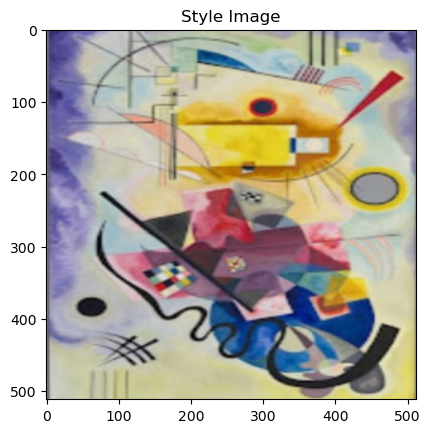

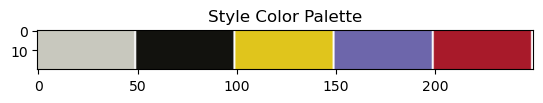

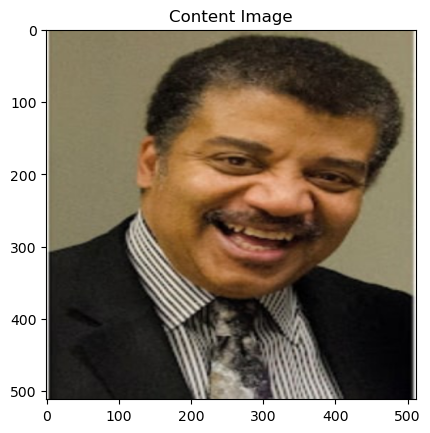

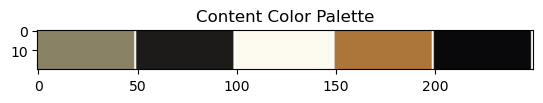

In [30]:
""" Image visualization"""

plt.ion()

style_img_color_palette_vis = torch.ones((1, 3, 20, 50 * PALETTE_SIZE),
                                         device=DEVICE)
content_img_color_palette_vis = torch.ones((1, 3, 20,50 * PALETTE_SIZE),
                                           device=DEVICE)


for c in range(PALETTE_SIZE):
    style_img_color_palette_vis[0, :, :, c * 50 : (c + 1) * 50 - 1] = (
        style_img_color_palette_vis[0, :, :, c * 50 : (c + 1) * 50 - 1] *
        style_palette[c, :].view(1, 3, 1, 1))
    content_img_color_palette_vis[0, :, :, c * 50 : (c + 1) * 50 - 1] = (
        content_img_color_palette_vis[0, :, :, c * 50 : (c + 1) * 50 - 1] *
        content_palette[c, :].view(1, 3, 1, 1))
  

plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(style_img_color_palette_vis, title='Style Color Palette')

plt.figure()
imshow(content_img, title='Content Image')

plt.figure()
imshow(content_img_color_palette_vis, title='Content Color Palette')



Mask Generation
This section generates masks based on color matching orders provided by the user. If SELECT_MATCHES is true, the user is prompted to input color matching orders, and the code then rearranges the color palettes accordingly. Masks are created for both style and content images using the color palettes.

Please enter color matching order.  For example to link the first color of content palette to the third color  in style palette, please enter: 0, 2
 This will be repeated until you  enter -1.
4,1
-1


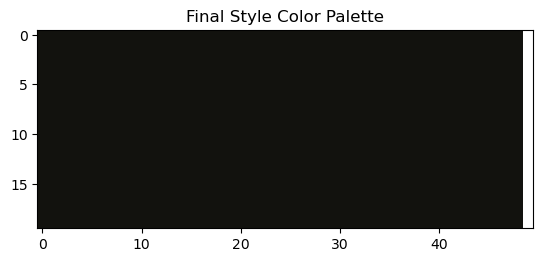

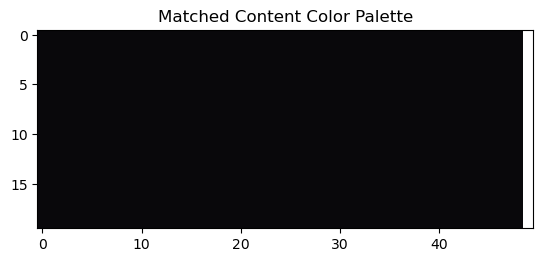

In [31]:
""" Mask generation"""

if SELECT_MATCHES:
    print('Please enter color matching order. ', 
  'For example to link the first color of content palette to the third color',
  ' in style palette, please enter: 0, 2\n This will be repeated until you ',
  'enter -1.')
    user_input = input()
    matching_order_content = []
    matching_order_style = []
    while user_input != '-1':
        parts = str.split(user_input, ',')
        c = int(parts[0])
        s = int(parts[1])
        assert style_palette.shape[0] > s and content_palette.shape[0] > c
        matching_order_content.append(c)
        matching_order_style.append(s)
        user_input = input()
    sorted_style_order = np.sort(matching_order_style)
    style_palette = style_palette[sorted_style_order, :]
    sorting_inds = list(np.argsort(matching_order_style).astype(int))
    sorted_content_order = [matching_order_content[i] for i in sorting_inds]
    content_palette = content_palette[sorted_content_order, :]
    PALETTE_SIZE = len(sorted_content_order)
    style_img_color_palette_vis = torch.ones((1, 3, 20, 50 * PALETTE_SIZE),
                                         device=DEVICE)
    content_img_color_palette_vis = torch.ones((1, 3, 20,50 * PALETTE_SIZE),
                                           device=DEVICE)

    for c in range(PALETTE_SIZE):
        style_img_color_palette_vis[0, :, :, c * 50 : (c + 1) * 50 - 1] = (
            style_img_color_palette_vis[0, :, :, c * 50 : (c + 1) * 50 - 1] *
              style_palette[c, :].view(1, 3, 1, 1))
        content_img_color_palette_vis[0, :, :, c * 50 : (c + 1) * 50 - 1] = (
            content_img_color_palette_vis[0, :, :, c * 50 : (c + 1) * 50 - 1] *
          content_palette[c, :].view(1, 3, 1, 1))
    
    plt.figure()
    imshow(style_img_color_palette_vis, title='Final Style Color Palette')

    plt.figure()
    imshow(content_img_color_palette_vis, title='Matched Content Color Palette')

    final_palette = content_palette.clone()
    mask_generator_style = CreateMask(color_palette=style_palette)
    mask_generator_content = CreateMask(color_palette=content_palette)

else:
    final_palette = torch.cat([style_palette, content_palette], dim=0)
    if ADD_BLACK_WHITE:
        black_white = torch.tensor([[0.0, 0.0, 0.0], [1.0, 1.0, 1.0]],
                           dtype=torch.float32, device=DEVICE)
        final_palette = torch.cat([final_palette, black_white], dim=0)

    final_palette = torch.unique(final_palette, dim=0)
    final_color_palette_vis = torch.ones((1, 3, 50, 50 * final_palette.shape[0]), 
                                     device=DEVICE)
    for c in range(final_palette.shape[0]):
        final_color_palette_vis[0, :, :, c * 50 : (c + 1) * 50 - 1] = (final_color_palette_vis[0, :, :, c * 50 : (c + 1) * 50 - 1] *final_palette[c, :].view(1, 3, 1, 1))
    plt.figure()
    imshow(final_color_palette_vis, title='Final Color Palette')
    mask_generator_style = CreateMask(color_palette=final_palette)
    mask_generator_content = CreateMask(color_palette=final_palette)


style_masks = mask_generator_style(style_img)

content_masks = mask_generator_content(content_img)

if SHOW_MASKS:
    for i in range(final_palette.shape[0]):
        plt.figure()
        imshow(style_masks[:, i, :, :], title=f'Style Mask of Color # {i}')
        plt.figure()
        imshow(content_masks[:, i, :, :], title=f'Content Mask of Color # {i}')
        

#Loading VGG Model

The code loads the VGG-19 model pretrained on ImageNet using PyTorch's models.vgg19 and moves it to the specified device (presumably GPU). The normalization mean and standard deviation values for the VGG model are also defined.

#Run Style Transfer

The actual style transfer process is executed in this section. The code initializes an input image (either a copy of the content image or random noise) and applies the style transfer algorithm using the run_style_transfer function. The resulting output image is then displayed using Matplotlib.

C:\Users\Manoj Kumar\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Manoj Kumar\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Building the style transfer model..


C:\Users\Manoj Kumar\AppData\Local\Temp\ipykernel_32648\1737559898.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(normalization_mean).view(-1, 1, 1)
C:\Users\Manoj Kumar\AppData\Local\Temp\ipykernel_32648\1737559898.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(normalization_std).view(-1, 1, 1)


Optimizing..
run [50]:
Content Loss: 15.810842 Color-Aware Loss: 21299.933594
run [100]:
Content Loss: 21.562645 Color-Aware Loss: 8912.211914
run [150]:
Content Loss: 25.324800 Color-Aware Loss: 5324.474121
run [200]:
Content Loss: 27.731504 Color-Aware Loss: 3763.844727
run [250]:
Content Loss: 30.049332 Color-Aware Loss: 2906.709717
run [300]:
Content Loss: 32.205624 Color-Aware Loss: 2307.762695


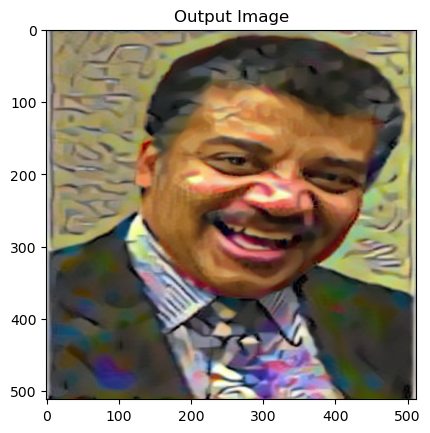

In [32]:
""" Loading VGG model"""

cnn = models.vgg19(pretrained=True).features.to(DEVICE).eval()

cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(DEVICE)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(DEVICE)


input_img = content_img.clone()
# if you want to use white noise instead uncomment the below line:
# input_img = torch.randn(content_img.data.size(), device=DEVICE)

""" Run style transfer"""

output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std, 
                            content_img, style_img, style_masks, 
                            update_masks=not SELECT_MATCHES)

plt.figure()
imshow(output, title='Output Image')

plt.ioff()
plt.show()


save_image(output.detach().squeeze(0), 'output.png')